<a href="https://colab.research.google.com/github/ajmoore12/WPA_Competition/blob/main/wpac_skillup_feature_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --upgrade google-cloud-bigquery-storage pandas

In [2]:
import torch
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

GPU Available: True
GPU Name: NVIDIA A100-SXM4-40GB
Using device: cuda


In [3]:
from google.colab import auth
auth.authenticate_user()
from google.cloud import bigquery
from google.colab import files
import pandas as pd

project_id = 'wpac-449904'
dataset_id = 'wpac_data'
# Create a storage client
client = bigquery.Client(project=project_id)

In [21]:
pd.set_option('display.max_columns', None)

survey = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.survey`").to_dataframe()
success = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.success_target`").to_dataframe()

In [5]:
survey.head()

,version,year_quarter,children,concern_finances,concern_health,concern_job,concern_job_search,concern_social,contract_work,current_job_benefits_childcare,current_job_benefits_education,current_job_benefits_health,current_job_benefits_none,current_job_benefits_other,current_job_benefits_pto,current_job_benefits_schedule,current_job_benefits_training,current_job_benefits_transportation,desired_industry,desired_industry_other,education,employment,employment_other,expenses_inflation,fed_quarter,gender,household_adult_children,household_decline,household_none,household_other,household_other_relatives,household_parents,household_siblings,household_spouse,household_young_children,income,income_covered_expenses,job_confidence,job_payment,job_payment_other,job_search_challenge,job_search_challenge_other,job_title,main_reason_looking,main_reason_other,new_job,new_job_better_advancement,new_job_better_benefits,new_job_better_commute,new_job_better_environment,new_job_better_hours,new_job_better_none,new_job_better_other,new_job_better_pay,new_job_better_title,new_job_company,new_job_field,new_job_income,new_job_industry,new_job_looking,previous_job_income,primary_work_schedule,public_benefits_childcare,public_benefits_decline,public_benefits_disability,public_benefits_eitc,public_benefits_medicare,public_benefits_none,public_benefits_pell,public_benefits_snap,public_benefits_tanf,public_benefits_ui,public_benefits_wioa,race,skillup_additional_resources,skillup_entry_reason_better_job,skillup_entry_reason_current_industry_skills,skillup_entry_reason_lost_job,skillup_entry_reason_new_industry_skills,skillup_feature,skillup_find_new_job,skillup_helpful_awareness_career,skillup_helpful_awareness_training,skillup_helpful_confidence_job,skillup_helpful_new_job,skillup_recommend,skillup_training,training_completed,training_enrolled,training_field,training_plan_to_enroll,training_program_provider,training_program_title,training_support_services,worked_past_six_months,years_experience,WPA_id
0,C1Q2,2023Q1,None,None,None,None,None,None,Yes,None,None,None,None,None,None,None,None,None,Healthcare,None,None,No,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Somewhat confident,I was paid an hourly wage.,None,Not hearing back from the places I apply to.,None,Dental assistant,Looking for a better work enviornment.,None,None,None,None,None,None,None,NaN,None,None,None,None,New field of work,None,None,Yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Recruiters on app,None,None,None,None,None,None,Somewhat helpful,Somewhat helpful,Somewhat helpful,None,5.0,No,In progress (completing in next 4-6 months),Yes,None,No,Egan,Na,No,Yes,5-10,WPA_343
1,C1Q3,2023Q2,None,None,None,None,None,None,Yes,None,None,None,None,None,None,None,None,None,Technology,None,None,"Yes, Full-Time (35 hours or more per week)",None,None,No,None,None,None,None,None,None,None,None,None,None,None,None,Somewhat confident,I am paid an hourly wage.,None,Need additional skills.,None,Dental assistant,Seeking a job with higher pay.,None,Yes,None,None,None,Yes,None,NaN,None,Yes,None,None,New field of work,"$30,000 - $39,999",None,Yes,"$20,000 - $29,999",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Somewhat helpful,Somewhat helpful,Somewhat helpful,Not so helpful,5.0,None,None,No,None,No,None,None,None,None,11-14,WPA_343
2,C1Q5,2024Q1,None,Extremely concerned,Slightly concerned,Slightly concerned,Slightly concerned,Extremely concerned,Yes,None,None,None,None,None,None,Yes,None,None,None,None,None,"Yes, Full-Time (35 hours or more per week)",None,Increased,None,None,None,None,None,None,None,None,None,None,None,None,No,None,I am paid an hourly wage.,None,None,None,Dental assistant,None,None,No,None,None,None,None,None,NaN,N/a,None,None,None,None,"$40,000 - $49,999",None,No,"$40,000 - $49,999",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,N/a,No,Somew

In [6]:
df = survey[['WPA_id', 'skillup_feature', 'skillup_recommend']].merge(success, on='WPA_id', how='left')
df.head()

,WPA_id,skillup_feature,skillup_recommend,target_success
0,WPA_343,None,5.0,1
1,WPA_343,None,5.0,1
2,WPA_343,N/a,5.0,1
3,WPA_343,None,5.0,1
4,WPA_343,None,10.0,1


In [10]:
median_recommendation = df['skillup_recommend'].median()
df['skillup_recommend'] = df['skillup_recommend'].fillna(median_recommendation)
for col in df.columns:
  print(df[col].value_counts(dropna=False))
print(df.info())

WPA_id
WPA_1889     7
WPA_9436     7
WPA_4223     7
WPA_5601     7
WPA_4194     7
            ..
WPA_72291    1
WPA_72283    1
WPA_72263    1
WPA_72260    1
WPA_72533    1
Name: count, Length: 10383, dtype: int64
skillup_feature
None                                         9258
Not sure                                      244
N/a                                           208
Na                                            197
Nothing                                        97
                                             ... 
Mobile App                                      1
Office hours for a mentor                       1
Newsletters                                     1
None that I could think of at the moment        1
More relatable jobs for my qualifications       1
Name: count, Length: 7439, dtype: int64
skillup_recommend
10.0    5788
8.0     3821
7.0     2434
5.0     1896
9.0     1874
6.0     1637
4.0      536
0.0      485
3.0      373
2.0      287
1.0      176
Name: count, dtype: 

In [13]:
df_filtered = df[(df['skillup_recommend'] <= 7.0) & (df['target_success'] == 0)].dropna(subset=['skillup_feature'])

In [14]:
df_filtered.value_counts(dropna=False)

,,,,count
WPA_id,skillup_feature,skillup_recommend,target_success,
WPA_5871,Not sure,5.0,0,3
WPA_69870,I'm not sure,0.0,0,2
WPA_35591,Free resume writing,6.0,0,2
WPA_43475,Na,7.0,0,2
WPA_36371,N/a,5.0,0,2
...,...,...,...,...
WPA_35064,Stop spamming me with jobs and training that do not match my skillset in any way.,2.0,0,1
WPA_35492,Na,3.0,0,1
WPA_3554,N/a,6.0,0,1


In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER Lexicon
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df_filtered['sentiment_score'] = df_filtered['skillup_feature'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Categorize Sentiment
df_filtered['sentiment_label'] = df_filtered['sentiment_score'].apply(lambda score: 'positive' if score > 0.05 else 'negative' if score < -0.05 else 'neutral')

# Display Sentiment Results
df_filtered[['WPA_id', 'skillup_feature', 'sentiment_score', 'sentiment_label']].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,WPA_id,skillup_feature,sentiment_score,sentiment_label
41,WPA_236,Nothing I can think of at the moment!,0.0000,neutral
245,WPA_1088,More free programs,0.5563,positive
247,WPA_1088,A handy app with loads of free materials,0.5106,positive
248,WPA_1088,Nothing I can think of right now,0.0000,neutral
249,WPA_1088,More free certifications,0.5563,positive


In [16]:
df_grouped = df_filtered.groupby('sentiment_label').agg(
    WPA_id=('WPA_id', 'nunique'),
    sentiment_score=('sentiment_score', 'mean')
).rename(columns={'WPA_id': 'No. of Respondents', 'sentiment_score': 'Avg. Sentiment Score'}) \
  .sort_values(by='Avg. Sentiment Score', ascending=False)

df_grouped

,No. of Respondents,Avg. Sentiment Score
sentiment_label,,
positive,200,0.468501
neutral,346,0.000000
negative,114,-0.269194


In [17]:
import spacy

# Load English NLP model
nlp = spacy.load("en_core_web_sm")

# Function to extract noun phrases
def extract_phrases(text):
    doc = nlp(text)
    return [' '.join(chunk.text.lower().split()) for chunk in doc.noun_chunks]

# Apply phrase extraction
df_filtered['extracted_phrases'] = df_filtered['skillup_feature'].apply(lambda x: extract_phrases(x))

# Display extracted phrases
df_filtered[['WPA_id', 'skillup_feature', 'extracted_phrases']].head()



,WPA_id,skillup_feature,extracted_phrases
41,WPA_236,Nothing I can think of at the moment!,"[nothing, i, the moment]"
245,WPA_1088,More free programs,[more free programs]
247,WPA_1088,A handy app with loads of free materials,"[a handy app, loads, free materials]"
248,WPA_1088,Nothing I can think of right now,"[nothing, i]"
249,WPA_1088,More free certifications,[more free certifications]


In [20]:
#Trying to extract phrases
from sklearn.feature_extraction.text import CountVectorizer

# Convert text to lowercase and remove punctuation
df_filtered['cleaned_text'] = df_filtered['skillup_feature'].str.lower().str.replace(r'[^\w\s]', '')

# Define function to extract top n-grams
def get_top_ngrams(corpus, n=2, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_counts = vectorizer.fit_transform(corpus)

    # Get n-gram frequency
    ngram_freq = ngram_counts.sum(axis=0).tolist()[0]
    ngram_list = vectorizer.get_feature_names_out()

    # Sort and return top phrases
    return sorted(zip(ngram_list, ngram_freq), key=lambda x: x[1], reverse=True)[:top_k]

# Extract bigrams (2-word phrases)
bigrams = get_top_ngrams(df_filtered['cleaned_text'].dropna(), n=2, top_k=15)

# Extract trigrams (3-word phrases)
trigrams = get_top_ngrams(df_filtered['cleaned_text'].dropna(), n=3, top_k=15)

# Print results
print("Top 15 Bigrams:", bigrams)
print("Top 15 Trigrams:", trigrams)


Top 15 Bigrams: [('don know', 25), ('training programs', 22), ('free training', 14), ('job search', 14), ('job opportunities', 10), ('job training', 10), ('job placement', 9), ('training opportunities', 9), ('entry level', 6), ('free programs', 6), ('career options', 5), ('im sure', 5), ('job postings', 5), ('training program', 5), ('actual jobs', 4)]
Top 15 Trigrams: [('free training programs', 3), ('actual job postings', 2), ('free resume writing', 2), ('hiring managers directly', 2), ('job placement services', 2), ('local training programs', 2), ('low income individuals', 2), ('training programs area', 2), ('100 miles denver', 1), ('20 years professional', 1), ('2nd chance opportunities', 1), ('54 computers curriculum', 1), ('ability better filter', 1), ('ability directly speak', 1), ('able certification having', 1)]


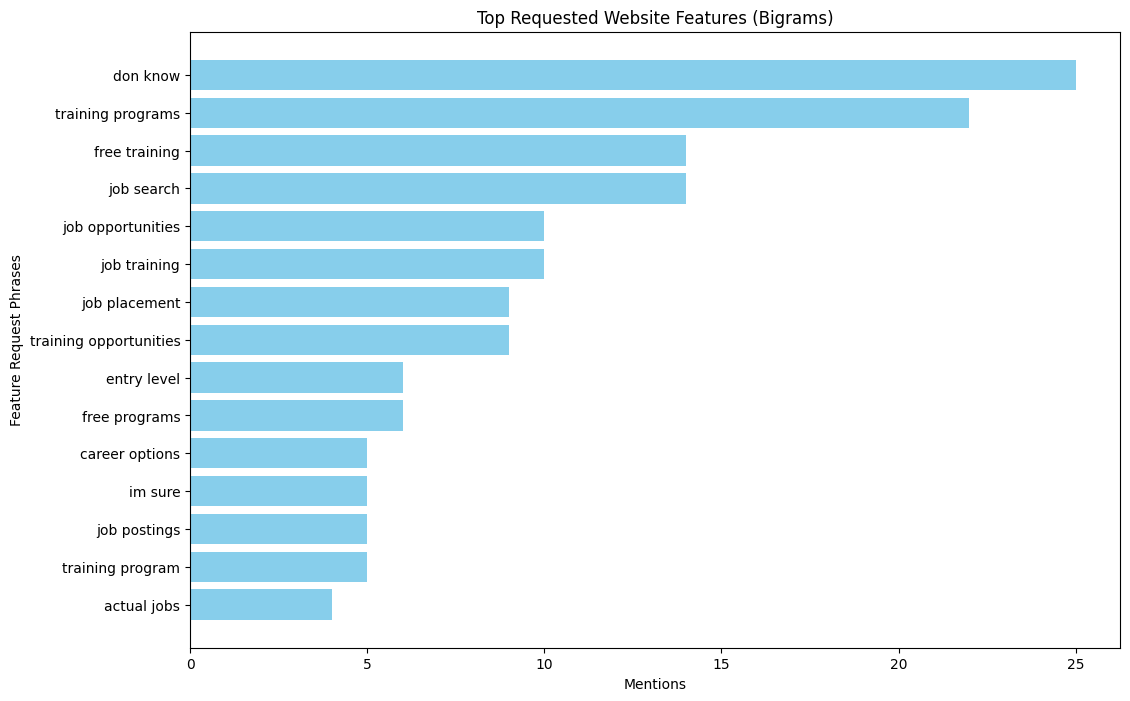

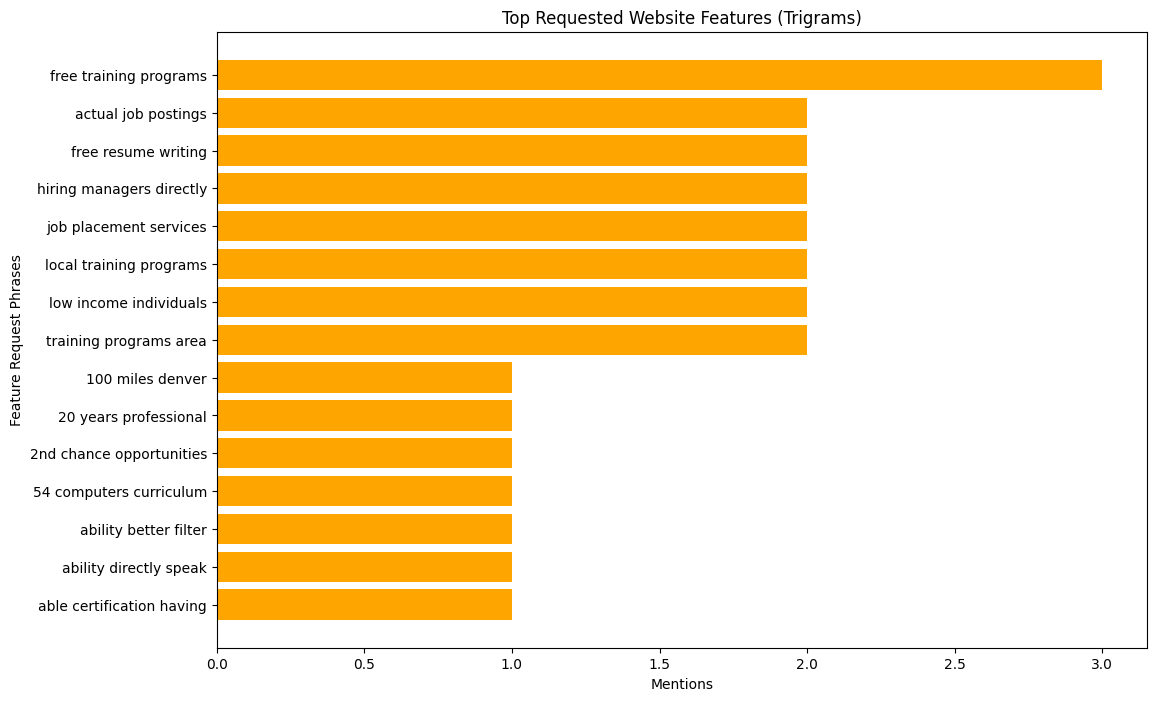

In [19]:
#Visualizing Phrases

import matplotlib.pyplot as plt

# Convert bigrams to a DataFrame for visualization
bigram_df = pd.DataFrame(bigrams, columns=['Phrase', 'Count'])
trigram_df = pd.DataFrame(trigrams, columns=['Phrase', 'Count'])

# Plot bigram frequency
plt.figure(figsize=(12, 8))
plt.barh(bigram_df['Phrase'], bigram_df['Count'], color='skyblue')
plt.xlabel("Mentions")
plt.ylabel("Feature Request Phrases")
plt.title("Top Requested Website Features (Bigrams)")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 8))
plt.barh(trigram_df['Phrase'], trigram_df['Count'], color='orange')
plt.xlabel("Mentions")
plt.ylabel("Feature Request Phrases")
plt.title("Top Requested Website Features (Trigrams)")
plt.gca().invert_yaxis()
plt.show()
